# Time Series Coursework
## 2022-12-16

#### CID: 01868678

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.linalg import toeplitz
from scipy.signal import find_peaks
import math as math

### Question 1

####  (a)

Suppose we have a Gaussian $\text{ARMA} \left(1, 1\right)$ process $X_t = \phi X_{t-1}+\epsilon_t-\theta \epsilon_{t-1}$. And consider the covariance matrix for $\left[X_0, \epsilon_0\right]^T$ which has the form

$$
D = 
\begin{bmatrix}
\text{Var}\{X_0\} & \text{Cov}\{X_0, \epsilon_0\} \\
\text{Cov}\{\epsilon_0, X_0\} & \text{Var}\{\epsilon_0\}
\end{bmatrix}
$$

By definition of $\{\epsilon_t\}$, we have $\text{Var}\{\epsilon_0\} = \sigma_{\epsilon}^2$.

To calculate $\text{Var}\{X_0\}$, use the original equation

$$
\begin{aligned}
\text{Var}\{X_0\} &= \phi^2 \text{ Var}\{X_{-1}\}+\sigma_{\epsilon}^2+\theta^2 \sigma_{\epsilon}^2+2\phi \text{ Cov}\{X_{-1}, \epsilon_0\}-2\theta\text{ Cov}\{\epsilon_0, \epsilon_{-1}\}-2\phi\theta\text{ Cov}\{X_{-1}, \epsilon_{-1}\} \\
&=\phi^2 \text{ Var}\{X_{0}\}+\sigma_{\epsilon}^2+\theta^2 \sigma_{\epsilon}^2-2\phi\theta\text{ Cov}\{X_{-1}, \epsilon_{-1}\}\\
&=\phi^2 \text{ Var}\{X_{0}\}+\sigma_{\epsilon}^2+\theta^2 \sigma_{\epsilon}^2-2\phi\theta E\{X_{-1}\epsilon_{-1}\}\\
&=\phi^2 \text{ Var}\{X_{0}\}+\sigma_{\epsilon}^2+\theta^2 \sigma_{\epsilon}^2-2\phi\theta \left(E\{\phi \epsilon_{-1}X_{-2}\}+E\{\epsilon_{-1}\epsilon_{-1}\}-E\{\theta \epsilon_{-1}\epsilon_{-2}\}\right)\\
&=\phi^2 \text{ Var}\{X_{0}\}+\sigma_{\epsilon}^2+\theta^2 \sigma_{\epsilon}^2-2\phi\theta \sigma_{\epsilon}^2
\end{aligned}
$$

as $\text{Var}\{X_{t}\} = \text{Var}\{X_{t-1}\}$ (stationarity), $E\{\epsilon_t\} = 0$ and independence between $X_{t-1}, \epsilon_t$ and $\epsilon_t, \epsilon_{t-1}$. Therefore, we have $\text{Var}\{X_0\} = \frac{\left(1+\theta^2 -2\phi\theta \right)\sigma_{\epsilon}^2 }{1-\phi^2}$.

And $\text{Cov}\{\epsilon_0, X_0\}=\text{Cov}\{X_0, \epsilon_0\}=E\{\epsilon_0 X_0\}=E\{\epsilon_0^2\}=\sigma_{\epsilon}^2$.

Now we have all the components of $D$, apply Cholesky decomposition of c such that $D = CC^T$ where $C$ is a lower triangular matrix. And sample randomly from standard Gaussian to simulate $\text{ARMA} \left(1, 1\right)$ process.

In [2]:
def ARMA11(phi, theta, sigma2, N):
    # Cholesky decomposition of D
    D = np.array([[((1+theta**2-2*theta*phi)*sigma2)/(1-phi**2), sigma2],[sigma2, sigma2]])
    C = np.linalg.cholesky(D)
    
    # sample randonly from standard Guassian and get Y
    y0 = np.random.normal(0, 1)
    y1 = np.random.normal(0, 1)
    Y = np.array([y0, y1])
    
    # calculate x0 and epsilon0
    x0 = (C@Y)[0]
    eps0 = (C@Y)[1]
    
    # simulate ARMA(1, 1)
    X = []
    epsold = eps0
    xold = x0
    for i in range(N):
        epsnew = np.random.normal(0, np.sqrt(sigma2))
        xnew = phi*xold + epsnew - theta*epsold
        epsold = epsnew
        xold = xnew
        X.append(xnew)
    return X

#### (b)

In [3]:
def acvs(X, tau):
    # define N and Xbar
    N = len(X)
    Xbar = np.mean(X)
    
    # calculate the estimator (formula from page 56 from notes)
    sol = []
    for j in range(len(tau)):
        s = 0
        for i in range(N-abs(tau[j])):
            s += (X[i] - Xbar)*(X[i+abs(tau[j])] - Xbar)
        shat = s/N
        sol.append(shat)
    return sol

#### (c)

In [4]:
def periodogram(X):
    # define N and Xbar
    N = len(X)
    
    # calculate the vector of fft of X_1 to X_N
    fftv = np.fft.fft(X)

    # Fourier transformation of X_t and relevant Fourier freuencies (formula from page 58 from notes)
    sol = []
    f = []
    for i in range(N):
        sol.append((abs(fftv[i])**2)/N)
        f.append(i/N - 0.5)
    sol = np.fft.fftshift(sol)
    
    return sol, f

### Question 2

#### Construct Sequences

In [6]:
# define initial value
N = [4, 8, 16, 32, 64, 128, 256, 512]
phi = -0.63
theta = 0.51
sigma2 = 2.21
Nr = 10000

In [7]:
# initial empty lists
S1_4, S2_4, S1_8, S2_8, S1_16, S2_16, S1_32, S2_32, S1_64, S2_64, S1_128, S2_128, S1_256, S2_256, S1_512, S2_512 = ([] for i in range(16))
S = [S1_4, S2_4, S1_8, S2_8, S1_16, S2_16, S1_32, S2_32, S1_64, S2_64, S1_128, S2_128, S1_256, S2_256, S1_512, S2_512]

# construct sequences S(p) at frequency N/4 and N/4+1
for j in range(len(N)):
    hj = N[j]/4
    for i in range(Nr):
        xi = ARMA11(phi, theta, sigma2, N[j])
        peri, f = periodogram(xi)
        S[j*2].append(peri[int(hj)]) # by symmetric
        S[j*2+1].append(peri[int(hj-1)]) # by symmetric

#### (a)

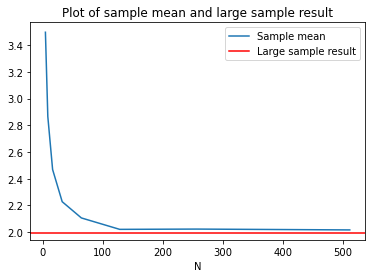

In [8]:
# calculate the mean of each N
mean = []
for i in range(8):
    mean.append(np.mean(S[i*2]))

# calculate S(f) of ARMA(1,1) by coefficients of time series (formula from page 52 from notes)
f = 1/4
Sf = sigma2*(((abs(1-theta*np.exp(-1j*2*np.pi*f)))**2)/((abs(1-phi*np.exp(-1j*2*np.pi*f)))**2))

# plot the graph
plt.plot(N, mean, label='Sample mean')
plt.axhline(Sf, color='r', label='Large sample result')
plt.title("Plot of sample mean and large sample result")
plt.xlabel("N") 
plt.legend()
plt.show()

#### (b)

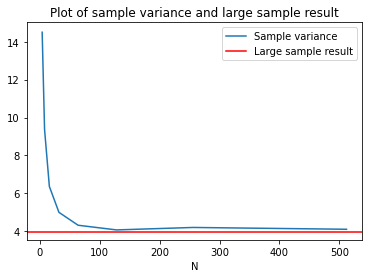

In [9]:
# calculate the variance of each N
var = []
for i in range(8):
    var.append(np.var(S[i*2]))

# result for large sample
f = 0.25
Sf2 = Sf**2

# plot the graph
plt.plot(N, var, label='Sample variance')
plt.axhline(Sf2, color='r', label='Large sample result')
plt.title("Plot of sample variance and large sample result")
plt.xlabel("N") 
plt.legend()
plt.show()

#### (c)

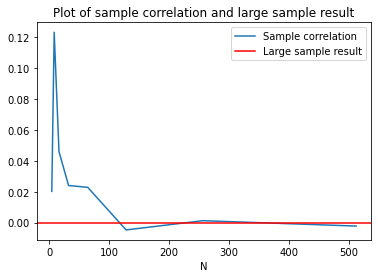

In [10]:
# calculate the correlation coefficient of each N
cor = []
for i in range(8):
    mi = np.corrcoef(S[i*2], S[i*2+1])
    cor.append(mi[0,1])
    
# plot the graph
plt.plot(N, cor, label='Sample correlation')
plt.axhline(0, color='r', label='Large sample result')
plt.title("Plot of sample correlation and large sample result")
plt.xlabel("N") 
plt.legend()
plt.show()

#### (d)

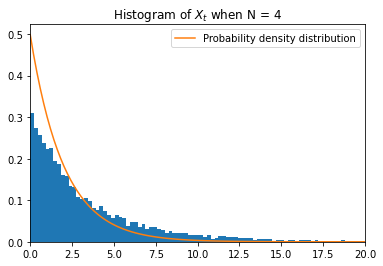

In [11]:
# define pdf of chi_2^2 distribution which is the same as exp(1/2)
def exp(x):
    sol = (1/2)*np.exp(-(1/2)*x)
    return sol

# plot the graph
x = np.linspace(0,20,100)
y = [exp(i)*Sf/2 for i in x] # asymptotic distribution
plt.hist(S[0], bins=200, density=True)
plt.plot(x, y, label='Probability density distribution')
plt.title("Histogram of $X_t$ when N = 4")
plt.xlim([0, 20])
plt.legend()
plt.show()

#### (e)

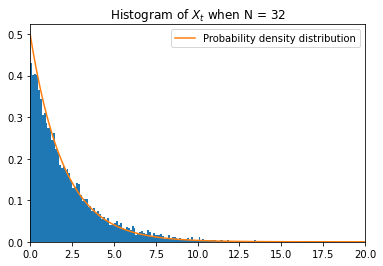

In [12]:
# plot the graph
x = np.linspace(0,20,100)
y = [exp(i)*Sf/2 for i in x] # asymptotic distribution
plt.hist(S[6], bins=200, density=True)
plt.plot(x, y, label='Probability density distribution')
plt.title("Histogram of $X_t$ when N = 32")
plt.xlim([0, 20])
plt.legend()
plt.show()

#### (f)

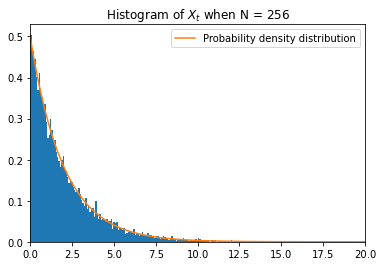

In [13]:
# plot the graph
x = np.linspace(0,20,100)
y = [exp(i)*Sf/2 for i in x] # asymptotic distribution
plt.hist(S[12], bins=200, density=True)
plt.plot(x, y, label='Probability density distribution')
plt.title("Histogram of $X_t$ when N = 256")
plt.xlim([0, 20])
plt.legend()
plt.show()

The plots above show that as $N$ increases, the mean of estimations $\hat{S}^{(p)}(f)$ will be closer to the real spectral density function $S(f)$. And the variance, correlation and distribution will follow the asymptotic properties. $\hat{S}^{(p)}(f)$ is asymptotically unbiased as an estimator of $S(f)$. 

### Question 3

In [5]:
ds = np.loadtxt("C:/Users/Yuning LI/Downloads/time_series_156.csv", delimiter = ",")

#### (a)

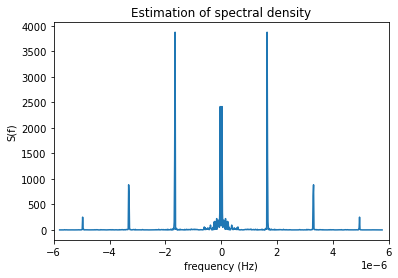

In [6]:
# centre the time series
dsbar = np.mean(ds)
ds = [x-dsbar for x in ds]

# construct cosine tapering (formula from page 64 from notes)
N = len(ds)
h = []
for i in range(math.floor(math.floor(0.5*N)/2)):
    h.append((1/2)*(1-np.cos((2*np.pi*(i+1))/(math.floor(N/2)+1))))
for i in range(math.floor(math.floor(0.5*N)/2), N+1-math.floor(math.floor(0.5*N)/2)):
    h.append(1)
for i in range(N+1-math.floor(math.floor(0.5*N)/2), N):
    h.append((1/2)*(1-np.cos((2*np.pi*(N+1-(i+1)))/(math.floor(N/2)+1))))
sumh = 0
for k in range(N):
    sumh += h[k]**2
C = np.sqrt(1/sumh) # normalizing constant
h = [C*ht for ht in h]

# perform tapering
hx = []
for j in range(N):
    hx.append(ds[j]*h[j])

# plot the graph
solhx, fhx = periodogram(hx)
fhx = [fh/86400 for fh in fhx]
x = np.linspace(0, N-1,N)
plt.plot(fhx, solhx)
plt.title("Estimation of spectral density")
plt.xlabel("frequency (Hz)")
plt.ylabel("S(f)")
plt.xlim([-6*10**(-6),6*10**(-6)])
plt.show()

There are 7 peaks from the spectrum with frequency around $\pm 5\times 10^{-6}$Hz, $\pm 3.5\times 10^{-6}$Hz, $\pm 1.8\times 10^{-6}$Hz and $0$Hz, which means that there is a cyclic structure in frequency domain at these frequencies. Around $\pm 1.8\times 10^{-6}$Hz there is the largest $S(f)$.

We need to centre the time series as we assumed the time series has $0$ mean when using autocovariance estimations to estimate spectrum. If the time series is not centred, there will be only one peak around $0$Hz in the spectrum. As the expectation of mean $\mu \ne 0$ and contain more random variations which will cover some underlying characteristics.

#### (b)

In [17]:
def AML(X, p):
    # define initial values
    N = len(X)
    F = np.zeros((N-p, p))
    Xp = X[p:]
    
    # construct F (formula from page 73 from notes)
    for i in range(N-p):
        for j in range(p):
            F[i,j] = X[p+i-j-1]
            
    # maximum likelihood
    theta = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@Xp
    sigma2 = (np.transpose(Xp-F@theta)@(Xp-F@theta))/(N-p)
    return theta, sigma2

In [18]:
def YW(X, p):
    # define initial values
    N = len(X)
    
    # cosine taper
    h = []
    for i in range(math.floor(math.floor(0.5*N)/2)):
        h.append((1/2)*(1-np.cos((2*np.pi*(i+1))/(math.floor(N/2)+1))))
    for i in range(math.floor(math.floor(0.5*N)/2), N+1-math.floor(math.floor(0.5*N)/2)):
        h.append(1)
    for i in range(N+1-math.floor(math.floor(0.5*N)/2), N):
        h.append((1/2)*(1-np.cos((2*np.pi*(N+1-(i+1)))/(math.floor(N/2)+1))))
    sumh = 0
    for k in range(N):
        sumh += h[k]**2
    C = np.sqrt(1/sumh) # normalizing constant
    h = [C*ht for ht in h]
    hx = []
    for j in range(N):
        hx.append(X[j]*h[j])
    
    # Yule-Walker (formula from page 66 from notes)
    tau = np.linspace(0, p, num = p+1)
    tau = [int(t) for t in tau]
    stau = acvs(hx, tau)
    stau = [i*N for i in stau]
    GAMMA = toeplitz(stau[0:p])
    gamma = stau[1:p+1]
    theta = np.linalg.inv(GAMMA)@gamma
    sigma2 = stau[0] - np.dot(theta, gamma)
    return theta, sigma2

#### (c)

In [19]:
# define initial values
h = 14
a = chi2.ppf(1-0.05, df=h)
N = len(ds)

X_aml = ds
L_aml = 100
p_aml = 1
    
# loop until fail to reject H0
while L_aml > a:
    # maximum likelihood
    theta_aml, sigma_aml = AML(X_aml, p_aml) 
    
    # calculate residual terms
    e_aml = []
    for i in range(p_aml+1, N+1):
        et_aml = X_aml[i-1]
        for j in range(1, p_aml+1):
            et_aml += -theta_aml[j-1]*X_aml[i-1-j]
        e_aml.append(et_aml)
        
    # calculate test statistic
    n_aml = len(e_aml)
    tau = np.linspace(0, h, num = h+1)
    tau = [int(t) for t in tau]
    acv_aml = acvs(e_aml, tau)
    L_aml = 0
    for k in range(1, h+1):
        L_aml += ((acv_aml[k]/acv_aml[0])**2)/(n_aml-k)
    L_aml = n_aml*(n_aml+2)*L_aml  
    
    # update p
    p_aml += 1
print(theta_aml, sigma_aml, p_aml)

[ 0.64372659  0.03233998  0.13227749 -0.10246404  0.03334437  0.05739101
  0.39006088 -0.24847022 -0.06984432  0.00822796  0.12119373 -0.09867805
 -0.09465869  0.23167923 -0.1117442   0.00328273 -0.12229458 -0.03384468
  0.0499223   0.06194433  0.30787579 -0.23502034] 2656.413891352038 23


In [20]:
# define initial values
X_yw = ds
L_yw = 100
p_yw = 1

# loop until fail to reject H0
while L_yw > a:
    # Yule Walker
    theta_yw, sigma_yw = YW(X_yw, p_yw) 
    
    # calculate residual terms
    e_yw = []
    for i in range(p_yw+1, N+1):
        et_yw = X_yw[i-1]
        for j in range(1, p_yw+1):
            et_yw += -theta_yw[j-1]*X_yw[i-1-j]
        e_yw.append(et_yw)
        
    # calculate test statistic
    n_yw = len(e_yw)
    acv_yw = acvs(e_yw, tau)
    L_yw = 0
    for k in range(1, h+1):
        L_yw += ((acv_yw[k]/acv_yw[0])**2)/(n_yw-k)
    L_yw = n_yw*(n_yw+2)*L_yw  
    
    # update p
    p_yw += 1
print(theta_yw, sigma_yw, p_yw)

[ 0.65008828  0.01058079  0.15727868 -0.1078226   0.03535482  0.08775253
  0.37412407 -0.26750593 -0.08293067 -0.01515462  0.10451308 -0.06666247
 -0.08361266  0.23126121 -0.1210614   0.02841325 -0.11894115 -0.0248992
  0.03092603  0.00876772  0.32023688 -0.21132621] 2809.163679465142 23


The smallest $p$ for both maximum likelihood and tapered Yule-Walker is 23, and the corresponding estimated parameter values were printed as $\textit{theta_aml}$, $\textit{sigma_aml}$ and $\textit{theta_yw}$, $\textit{sigma_yw}$.

#### (d)

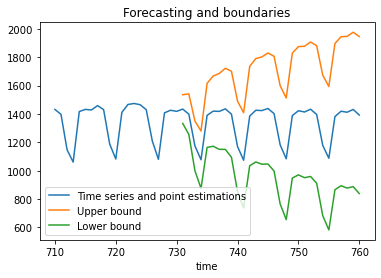

In [21]:
# define initial values
p = len(theta_aml)
N = len(ds)
ds1 = np.loadtxt("C:/Users/Yuning LI/Downloads/time_series_156.csv", delimiter = ",")
ds1 = [x for x in ds1]
sigmae = np.sqrt(np.var(e_aml))
up = []
low = []

# forecasting from 731 to 760 and calculate upper and lower bounds
for i in range(30):
    xt = 0
    for j in range(p):
        xt += theta_aml[j]*(ds[N+i-j-1])
    ds.append(xt) # without mean
    ds1.append(xt+dsbar) # with mean
    up.append(ds1[i+730] + 1.96*np.sqrt(i+1)*sigmae)
    low.append(ds1[i+730] - 1.96*np.sqrt(i+1)*sigmae)

# plot the graph
x = np.linspace(710, 760, num = 51)
y = np.linspace(731, 760, num = 30)
plt.plot(x, ds1[709:760], label='Time series and point estimations')
plt.plot(y, up, label='Upper bound')
plt.plot(y, low, label='Lower bound')
plt.title("Forecasting and boundaries")
plt.xlabel("time") 
plt.legend()
plt.show()

There is a 95% probability that the future energy consumption from day 731 to day 760 will lies in the region bounded by the upper bound and lower bound.